# Notebook to recreate 

A Discriminative Feature Learning Approach for Deep Face Recognition

Not using the same exact networks so expecting slightly different results

In [1]:
import itertools

import jax
import jax.numpy as jnp  # JAX NumPy
import matplotlib.pyplot as plt
import optax  # For SGD
from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

from jax_center_loss.data import get_train_test_keras_datasets

In [2]:
%load_ext autoreload
%autoreload 2

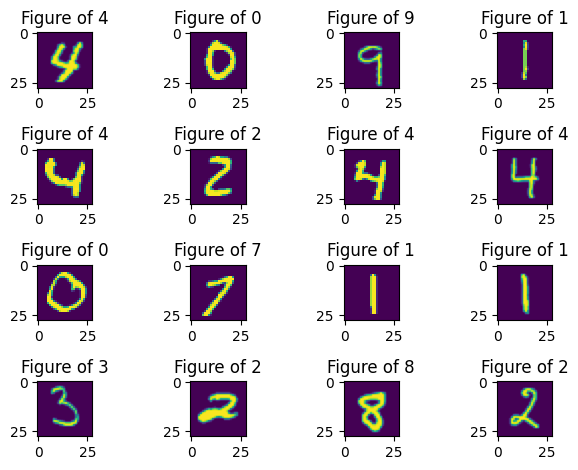

In [3]:
train, test = get_train_test_keras_datasets(batch_size=32)
fig, axs = plt.subplots(4, 4)
batch_x, batch_y = train[0]
for n, (i, j) in enumerate(itertools.product(range(4), range(4))):
    axs[i, j].imshow(batch_x[n, :, :, 0])
    axs[i, j].set_title(f"Figure of {batch_y[n]}")
fig.tight_layout()

In [4]:
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

gpu


In [5]:
import numpy as np

# Convelutional neural network - adapted from flax tutorial.

We do one adaptation which is add a penultimate layer with 2 dimenions for the center loss part.

This is so we have a low dimensional representation of each figure in 2d space.

# A standard CNN.

output is the logits and the latent representation of each image.

We can re-use this model for both center loss & standard

In [6]:
class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(5, 5))(x)
        x = nn.PReLU()(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=42, kernel_size=(5, 5))(x)
        x = nn.PReLU()(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.PReLU()(x)
        x = nn.Dense(features=16)(x)
        x = nn.PReLU()(x)
        x = nn.Dense(features=8)(x)
        x = nn.soft_sign(x)
        latent_features = nn.Dense(features=2, use_bias=False)(x)
        out = nn.Dense(features=10, name="latent_features")(latent_features)
        return out, latent_features

# Core components

Cross entropy loss, metrics, code to create the initial state

The code to train for a full epoch.

These parts will need to change quite majorly for center loss

In [7]:
center_weight = 0.01  # TODO: Find a good way to set this


def cross_entropy_loss(logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)

    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()


def compute_metrics(logits, params, latent_features, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    center_loss = calculate_center_loss(params["centers"], latent_features, labels)
    pred_label = jnp.argmax(logits, -1)
    accuracy = jnp.mean(pred_label == labels)
    metrics = {"loss": loss, "accuracy": accuracy, "center_loss": center_loss}
    return metrics


def create_train_state(rng, learning_rate):
    """Creates initial `TrainState`."""
    cnn = CNN()
    # 1,28,28 is the image size (batch size 1)
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))["params"]
    tx = optax.adam(learning_rate)
    hidden_dim, n_class = params["latent_features"]["kernel"].shape
    params["centers"] = jnp.zeros([n_class, hidden_dim])
    state = train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)
    return state


@jax.jit
def calculate_center_loss(centers, latent_features, labels):
    """MSE from the relevant centers"""
    centers = jnp.take(centers, labels, axis=0)
    error = centers - latent_features
    return jnp.square(error).sum(axis=1).mean()


@jax.jit
def train_step(state, batch):
    """Train for a single step."""

    def loss_fn(params):
        logits, latent_features = CNN().apply({"params": params}, batch[0])
        loss_ce = cross_entropy_loss(logits=logits, labels=batch[1])
        loss_center = calculate_center_loss(
            params["centers"], latent_features, batch[1]
        )
        return loss_ce + center_weight * loss_center, (logits, latent_features)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (logits, latent_features)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(
        logits=logits,
        params=state.params,
        latent_features=latent_features,
        labels=batch[1],
    )
    return state, metrics


@jax.jit
def eval_step(params, batch):
    logits, latent_features = CNN().apply({"params": params}, batch[0])
    return compute_metrics(
        logits=logits, params=params, latent_features=latent_features, labels=batch[1]
    )


def train_epoch(state, train_ds, epoch, rng):
    """Train for a single epoch."""
    batch_metrics = []
    for batch in train_ds:
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {}
    for k in batch_metrics_np[0]:
        data = [metrics[k] for metrics in batch_metrics_np]
        epoch_metrics_np[k] = np.mean(data)

    print(
        "train epoch: %d, loss: %.4f, accuracy: %.2f"
        % (epoch, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"] * 100)
    )
    train_ds.on_epoch_end()
    return state


def evaluate_epoch(state, dataset):
    """Train for a single epoch."""

    batch_metrics = []
    for batch in dataset:
        metrics = eval_step(state.params, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: float(np.mean([metrics[k] for metrics in batch_metrics_np]))
        for k in batch_metrics_np[0]
    }
    return epoch_metrics_np

# Train the standard CNN and plot the results

In [8]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 0.001
momentum = 0.9
num_epochs = 30
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [9]:
from flax.training.early_stopping import EarlyStopping

early_stop = EarlyStopping(min_delta=1e-3, patience=3)
for epoch in range(1, num_epochs + 1):
    state = train_epoch(state, train, epoch, rng)
    test_metrics = evaluate_epoch(state, test)
    train_metrics = evaluate_epoch(state, train)
    print(f"eval train : {train_metrics}, eval_test {test_metrics}")
    early_stop = early_stop.update(-test_metrics["accuracy"])
    if early_stop.should_stop:
        print(f"Met early stopping criteria, breaking at epoch {epoch}")
        break

train epoch: 1, loss: 0.8199, accuracy: 80.21
eval train : {'accuracy': 0.972350001335144, 'center_loss': 8.141839027404785, 'loss': 0.41791796684265137}, eval_test {'accuracy': 0.9759615659713745, 'center_loss': 8.24824047088623, 'loss': 0.4071972072124481}
train epoch: 2, loss: 0.3114, accuracy: 97.32
eval train : {'accuracy': 0.9755499958992004, 'center_loss': 4.516913890838623, 'loss': 0.23975184559822083}, eval_test {'accuracy': 0.9772636294364929, 'center_loss': 4.516234397888184, 'loss': 0.22519508004188538}
train epoch: 3, loss: 0.1745, accuracy: 98.24
eval train : {'accuracy': 0.9863333106040955, 'center_loss': 1.9135102033615112, 'loss': 0.1222572922706604}, eval_test {'accuracy': 0.9858773946762085, 'center_loss': 1.9467612504959106, 'loss': 0.12641403079032898}
train epoch: 4, loss: 0.1218, accuracy: 98.53
eval train : {'accuracy': 0.9910500049591064, 'center_loss': 0.7998080253601074, 'loss': 0.08457234501838684}, eval_test {'accuracy': 0.987379789352417, 'center_loss': 0.

### Plot a sub sample of the "latent features" and the dense weights for the last layer.

In [10]:
@jax.jit
def predict_latent(state, images):
    return CNN().apply({"params": state.params}, images)[1]


def predict_dataset(state, dataset):
    out_latent = []
    out_truth = []
    for batch in dataset:
        out_latent.append(predict_latent(state, batch[0]))
        out_truth.append(batch[1])
    return np.vstack(out_latent), np.hstack(out_truth)


latent, label = predict_dataset(state, test)

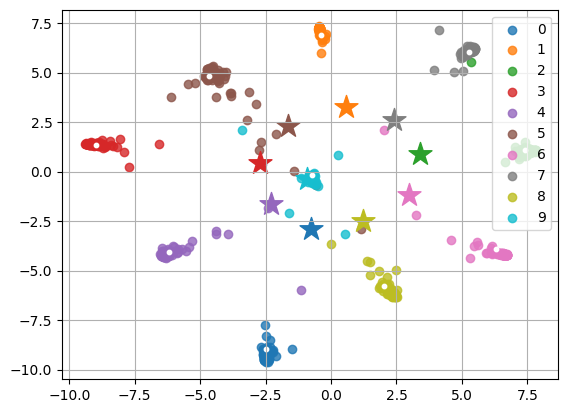

In [11]:
import matplotlib as mpl

cmap = mpl.colormaps["tab10"]
fig, axs = plt.subplots()
plot_subsample = latent[:1000]
plot_subsample_labels = label[:1000]
for i in range(10):
    mask = plot_subsample_labels == i
    axs.scatter(
        plot_subsample[mask, 0],
        plot_subsample[mask, 1],
        color=cmap(i),
        label=str(i),
        alpha=0.8,
    )
for i in range(10):
    point = state.params["latent_features"]["kernel"][:, i]
    center = state.params["centers"][i, :]
    axs.scatter(point[0], point[1], color=cmap(i), marker="*", s=300)
    axs.scatter(center[0], center[1], color="white", marker="o", s=10)
axs.legend(loc="upper right")
axs.grid()

fig.savefig("images/center_loss.png")